In [107]:
import numpy as np
import collections
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os
import nltk
from keras.preprocessing import sequence
%matplotlib inline

In [108]:
DATA_DIR = "./data"

train_data = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
train_data.head()

,sentence,label
0,I hate Harry Potter.,0
1,The first action theme to be played as the fir...,1
2,"Always knows what I want, not guy crazy, hates...",0
3,"Is it just me, or does Harry Potter suck?...",0
4,friday hung out with kelsie and we went and sa...,0


In [109]:
num_recs = len(train_data) # number of total sentences
print(num_recs)

5668


In [110]:
maxlen = 0 # maximum sentence length
word_freqs = collections.Counter() # word frequency

for index, row in train_data.iterrows():
    words = nltk.word_tokenize(row['sentence'].lower())
    if (len(words) > maxlen):
        maxlen = len(words)
    for word in words:
        word_freqs[word] += 1
print(len(word_freqs))
print(maxlen)

# word_freqs: (word, freqs)

2094
42


In [111]:
MAX_FEATURES = 2094 # number of unique words
MAX_SENTENCE_LENGTH = 42 # maximum sentence length

In [112]:
vocab_size = MAX_FEATURES + 2
word2index = word2index = {x[0]: i+2 for i, x in enumerate(word_freqs.most_common(MAX_FEATURES))}
# word_freqs: (word, count)

word2index["PAD"] = 0
word2index["UNK"] = 1
# word2index: (word, index), from most to least

index2word = {v:k for k, v in word2index.items()}
# word2index: (index, word), from most to least

In [113]:
# print(word2index)

In [132]:
data_X_in = np.empty((num_recs, ), dtype=list)
data_y = np.zeros((num_recs, ))
i = 0

for index, row in train_data.iterrows():
    words = nltk.word_tokenize(row['sentence'].lower())
    seqs = []
    for word in words:
        if word in word2index:
            seqs.append(word2index[word])
        else:
            seqs.append(word2index["UNK"])
    data_X_in[i] = seqs
    data_y[i] = int(row['label'])
    i += 1

In [135]:
data_X_in = sequence.pad_sequences(data_X_in, padding='post', value=word2index['PAD'], maxlen=MAX_SENTENCE_LENGTH)

In [137]:
print(data_X_in[:5])
print(data_X_in.shape)

[[  2  30   7  14   4   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  5 111 388 365  25  49 450  34   5 586 110 378  19   5 587  20  21 151
  365  61  19  18 106 588  25   5 589   3 590   6 591 492  89 592   4   0
    0   0   0   0   0   0]
 [152 159 127   2  63   3  73  87 171   3 166   7  50   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [ 17  24  47  67   3  57 172   7  14  53 160  15   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [157 200  52  45 201   6  44 110   6 117   5  12  10  13  32   8   8   8
    8   8   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]]
(5668, 42)


In [138]:
print(data_y[:5])
print(data_y.shape)

[0. 1. 0. 0. 0.]
(5668,)


In [139]:
def data_generator(batch_size):
    while True:
        for i in range(0,len(data_X_in),batch_size):
            if i + batch_size < len(data_X_in):
                yield data_X_in[i:i + batch_size], data_y[i:i + batch_size]

## Model Part

In [184]:
batch_size = 24
embedding_size = 100
vocab_size = MAX_FEATURES + 2
num_units = 64
NUM_EPOCHS = 10

In [190]:
import tensorflow as tf
import tflearn
tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)

In [191]:
tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)

with tf.device('/gpu:1'):
    initializer = tf.random_uniform_initializer(
        -0.08, 0.08)
    tf.get_variable_scope().set_initializer(initializer)
    x = tf.placeholder("int32", [None, None])
    y = tf.placeholder("int32", [None])
    x_len = tf.placeholder("int32",[None])
    
    learning_rate = tf.placeholder(tf.float32, shape=[])
    
    # embedding
    embedding_encoder = tf.get_variable(
        "embedding_encoder", [vocab_size, embedding_size],dtype=tf.float32)
    encoder_emb_inp = tf.nn.embedding_lookup(
        embedding_encoder, x)
    
    # Build RNN cell
    encoder_cell = tf.contrib.rnn.BasicLSTMCell(num_units)
    
    encoder_cell = tf.contrib.rnn.DropoutWrapper(cell=encoder_cell, output_keep_prob=0.75)
    # Run Dynamic RNN
    #   encoder_outputs: [max_time, batch_size, num_units]
    #   encoder_state: [batch_size, num_units]
    encoder_outputs, encoder_state = tf.nn.dynamic_rnn(
        encoder_cell, encoder_emb_inp,
        sequence_length=x_len, time_major=False,dtype=tf.float32)
    
    model_logistic = tf.layers.dense(encoder_state[0],1)
    model_pred = tf.nn.sigmoid(model_logistic)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(y,tf.float32),logits=tf.reshape(model_logistic,(-1,)))
    loss = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(loss)

In [192]:
session.run(tf.global_variables_initializer())

In [193]:
from utils import ProgressBar

losses = []
beginning_lr = 0.1
gen = data_generator(batch_size)
for one_epoch in range(0,1):
    pb = ProgressBar(worksum=len(data_X_in))
    pb.startjob()
    for one_batch in range(0,len(data_X_in),batch_size):
        batch_x,batch_y = gen.__next__()
        batch_x_len = np.asarray([len(i) for i in batch_x])
        batch_lr = beginning_lr 
        
        _,batch_loss = session.run([optimizer,loss],feed_dict={
            x:batch_x,
            y:batch_y,
            x_len:batch_x_len,
            learning_rate:batch_lr,
        })
        pb.info = "EPOCH {} batch {} lr {} loss {}".format(one_epoch,one_batch,batch_lr,batch_loss)
        pb.complete(batch_size)
        losses.append(batch_loss)

EPOCH 0 batch 5664 lr 0.1 loss 0.1634032279253006 100.35 % [==================================================>] 5688/5668 	 used:15s eta:0 s

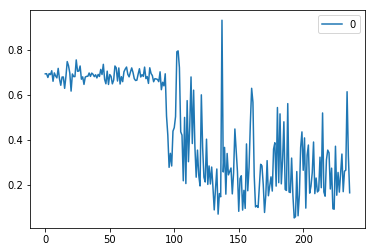

In [194]:
%matplotlib inline
pd.DataFrame(losses).plot()


## run predict 

In [258]:
test_data = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
print(test_data.head())

test_recs = len(test_data)
print(test_recs)

                                            sentence
0            I liked the first " Mission Impossible.
1                              I love Harry Potter..
2  Not because I hate Harry Potter, but because I...
3  the story of Harry Potter is a deep and profou...
4  The complaints I've seen about the " Vito-bein...
1418


In [259]:
def predict_result(sent):
    words = nltk.word_tokenize(row['sentence'].lower())
    senttoken = [word2index.get(word,word2index['UNK']) for word in words]
    inputx = np.asarray([senttoken])
    inputx_len = np.asarray([len(senttoken)])
    batch_predict = session.run(model_pred,feed_dict={
            x:inputx,
            x_len:inputx_len,
        })[0]
    return 1 if batch_predict > 0.5 else 0

In [260]:
labels = []
for index, row in test_data.iterrows():
    label = predict_result(row['sentence'])
    labels.append(label)

In [261]:
print(len(labels))

1418


In [262]:
COLUMN_NAMES = ['sentence', 'label']
df = pd.DataFrame(columns=COLUMN_NAMES)

df['sentence'] = test_data['sentence']
ll = pd.Series(labels)
df['label'] = ll.values
print(df.shape)

(1418, 2)


In [263]:
print(df.head())

                                            sentence  label
0            I liked the first " Mission Impossible.      1
1                              I love Harry Potter..      1
2  Not because I hate Harry Potter, but because I...      0
3  the story of Harry Potter is a deep and profou...      1
4  The complaints I've seen about the " Vito-bein...      1


In [264]:
df.to_csv(os.path.join(DATA_DIR, "submission.csv"), index=False)

In [265]:
y_test = pd.read_csv(os.path.join(DATA_DIR, "result.csv")) # 正确答案

In [266]:
print(y_test.head())

                                            sentence  label
0            I liked the first " Mission Impossible.      1
1                              I love Harry Potter..      1
2  Not because I hate Harry Potter, but because I...      0
3  the story of Harry Potter is a deep and profou...      1
4  The complaints I've seen about the " Vito-bein...      0
